# 🧪 Đánh giá mô hình ABSA (UIT-ViSFD)

Notebook này giúp bạn **đánh giá đầu ra LLM** so với **nhãn chuẩn (ground truth)** cho tác vụ **Aspect-Based Sentiment Analysis** (trích rút khía cạnh & phân loại cảm xúc theo khía cạnh).

**Bạn sẽ nhận được:**
- Chấm điểm **trích rút khía cạnh** (Precision/Recall/F1 – micro).
- Chấm điểm **cặp (Khía cạnh, Cảm xúc)** (Precision/Recall/F1 – micro).
- Báo cáo **phân loại cảm xúc** trên các khía cạnh **đã khớp** (Confusion matrix + classification report).
- Bảng **F1 theo từng khía cạnh**, cả cho **trích rút khía cạnh** và **cảm xúc**.
- Bảng **Error analysis**: thiếu khía cạnh (FN), thừa khía cạnh (FP), cảm xúc sai.

> ⚠️ Lưu ý: Bạn có thể **bật/tắt** việc tính điểm cho các khía cạnh tổng quát như `GENERAL`, `OTHERS` (vì mỗi team có cách dùng khác nhau) ở phần cấu hình bên dưới.


In [1]:
# ========================
# 1) Thiết lập đường dẫn & tham số
# ========================
GROUND_TRUTH_CSV = "/Users/hatrungkien/my-sentiment/data/raw/UIT-ViSFD/Test.csv"
PREDICTIONS_CSV = "/Users/hatrungkien/my-sentiment/outputs/absa/viqwen_3b_local/uit/uit_absa_2224.csv"

# Bỏ qua (không tính điểm) cho một số khía cạnh nếu muốn (ví dụ: GENERAL, OTHERS)
IGNORE_ASPECTS = {"GENERAL", "OTHERS"}  # để trống: set()

# Tùy chọn: nếu một khía cạnh được dự đoán nhưng không có sentiment kèm theo,
#    nên gán tạm là 'Neutral' hay bỏ qua? Ở đây mặc định gán 'Neutral' để tính điểm cặp.
FILL_MISSING_SENTIMENT_WITH = "Neutral"  # hoặc None để bỏ qua

# Nếu nhiều câu (sent_idx) trong cùng 1 review dự đoán cảm xúc khác nhau cho cùng 1 khía cạnh,
#    ta sẽ lấy **đa số (majority vote)**. Nếu hòa, mặc định ưu tiên theo thứ tự: Negative > Positive > Neutral.
TIE_BREAKER_ORDER = ["Negative", "Positive", "Neutral"]

# Chế độ hiển thị vài dòng đầu để sanity-check
PRINT_SAMPLE_ROWS = 3


In [2]:
# ========================
# 2) Import thư viện & hàm trợ giúp
# ========================
import re
import ast
import json
from collections import Counter, defaultdict
from typing import Dict, List, Set, Tuple

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# --------- Chuẩn hóa nhãn cảm xúc ---------
def normalize_sentiment(s):
    """Đưa sentiment về một trong {Positive, Negative, Neutral}."""
    if s is None:
        return None
    s = str(s).strip().lower()
    table = {
        "pos": "Positive", "positive": "Positive", "+": "Positive",
        "neg": "Negative", "negative": "Negative", "-": "Negative",
        "neu": "Neutral",  "neutral":  "Neutral",  "0": "Neutral",
    }
    return table.get(s, s.capitalize())

# --------- Chuẩn hóa tên khía cạnh (taxonomy) ---------
# Bạn có thể bổ sung alias tại đây để map về bộ khía cạnh chuẩn của UIT-ViSFD
ASPECT_ALIASES = {
    # Màn hình
    "screen": "SCREEN", "display": "SCREEN", "màn hình": "SCREEN",
    # Pin
    "battery": "BATTERY", "pin": "BATTERY",
    # Camera
    "camera": "CAMERA", "cam": "CAMERA",
    # Lưu trữ/bộ nhớ
    "storage": "STORAGE", "memory": "STORAGE", "rom": "STORAGE", "ram": "STORAGE",
    # Thiết kế
    "design": "DESIGN", "thiết kế": "DESIGN",
    # Hiệu năng
    "performance": "PERFORMANCE", "speed": "PERFORMANCE", "hiệu năng": "PERFORMANCE",
    # Dịch vụ & phụ kiện
    "ser&acc": "SER&ACC", "service": "SER&ACC", "support": "SER&ACC",
    "chăm sóc khách hàng": "SER&ACC", "bảo hành": "SER&ACC",
    # Tính năng / thiết lập
    "features": "FEATURES", "setup": "FEATURES", "tính năng": "FEATURES",
    "soft": "FEATURES", "phần mềm": "FEATURES",
    # Âm thanh
    "sound": "SOUND", "audio": "SOUND", "loa": "SOUND",
    # Giá
    "price": "PRICE", "giá": "PRICE",
    # Chung/khác
    "general": "GENERAL", "others": "OTHERS", "other": "OTHERS"
}

def canonicalize_aspect(a):
    """Đưa tên khía cạnh (dự đoán/ground truth) về dạng chuẩn (UPPERCASE).
    - Loại bỏ khoảng trắng thừa, bỏ dấu nháy.
    - Map qua bảng alias nếu cần.
    """
    if a is None:
        return None
    a0 = str(a).strip().strip('"\'').lower()
    # một số chuẩn hóa nhẹ
    a0 = a0.replace("&amp;", "&")
    a0 = re.sub(r"\s+", " ", a0)
    return ASPECT_ALIASES.get(a0, a0.upper())

# --------- Parse ground-truth (UIT-ViSFD) ---------
# Định dạng label ví dụ: {SCREEN#Positive};{FEATURES#Negative};{OTHERS};
def parse_gt_labels(label_str: str) -> Dict[str, str]:
    result = {}
    if pd.isna(label_str) or not str(label_str).strip():
        return result
    parts = str(label_str).split(";")
    for item in parts:
        item = item.strip()
        if not item:
            continue
        item = item.strip("{} ")
        if not item:
            continue
        if "#" in item:
            asp, sent = item.split("#", 1)
            asp = canonicalize_aspect(asp)
            sent = normalize_sentiment(sent)
        else:
            asp = canonicalize_aspect(item)
            # Nếu không có sentiment (ví dụ OTHERS), đánh nhãn Neutral tạm thời
            sent = "Neutral"
        if asp:
            result[asp] = sent
    return result

# --------- Parse predictions (list/dict dạng chuỗi) ---------
def _robust_literal_eval(text):
    """Cố gắng ast.literal_eval; nếu lỗi thì ráng sửa format."""
    if pd.isna(text):
        return None
    s = str(text).strip()
    if not s:
        return None
    try:
        return ast.literal_eval(s)
    except Exception:
        # Thử convert ' -> " và parse JSON
        try:
            s2 = s.replace("'", '"')
            return json.loads(s2)
        except Exception:
            return None

def parse_pred_aspects(s) -> List[str]:
    """Parse cột 'aspects' (chuỗi list) -> list đã chuẩn hóa."""
    raw = _robust_literal_eval(s)
    out = []
    if isinstance(raw, (list, tuple)):
        for a in raw:
            ca = canonicalize_aspect(a)
            if ca:
                out.append(ca)
    else:
        # fallback: tách thô theo dấu phẩy bên trong []
        st = str(s).strip().strip("[]")
        toks = [t.strip().strip("'\"") for t in st.split(",") if t.strip()]
        for a in toks:
            ca = canonicalize_aspect(a)
            if ca:
                out.append(ca)
    return out

def parse_pred_sentiments(s) -> Dict[str, str]:
    """Parse cột 'sentiments' (chuỗi dict) -> dict {ASPECT: Sentiment} (đã chuẩn hóa)."""
    raw = _robust_literal_eval(s)
    out = {}
    if isinstance(raw, dict):
        for k, v in raw.items():
            ck = canonicalize_aspect(k)
            sv = normalize_sentiment(v)
            if ck:
                out[ck] = sv
        return out
    
    # fallback: regex match kiểu: key: 'Value'
    text = str(s)
    for m in re.finditer(r"([A-Za-zÀ-ỹ&\s]+)\s*:\s*['\"]?(Positive|Negative|Neutral|pos|neg|neu)['\"]?", text, re.I):
        k, v = m.group(1), m.group(2)
        ck = canonicalize_aspect(k)
        sv = normalize_sentiment(v)
        if ck:
            out[ck] = sv
    return out

# --------- Gộp dự đoán theo review_id (aggregate) ---------
def aggregate_predictions(df_pred: pd.DataFrame,
                          tie_breaker_order=("Negative", "Positive", "Neutral"),
                          fill_missing= "Neutral"):
    """
    Gộp dự đoán ở cấp **review**.
    - Hợp nhất tất cả 'aspects' và 'sentiments' của các câu (sent_idx) thuộc cùng review_id.
    - Nếu 1 khía cạnh có nhiều sentiment khác nhau -> lấy **đa số** (majority vote).
      Khi hòa -> ưu tiên theo thứ tự tie_breaker_order.
    - Nếu một khía cạnh chỉ xuất hiện trong 'aspects' mà **không có** sentiment tương ứng,
      thì gán fill_missing (mặc định 'Neutral').
    Trả về:
    - pred_aspects_dict: {rid: set(aspects)}
    - pred_sents_dict:   {rid: {ASPECT: Sentiment}}
    """
    pred_aspects_dict = {}
    pred_sents_dict   = {}
    
    # Gom theo review_id
    for rid, g in df_pred.groupby("review_id"):
        aspects_set = set()
        votes = defaultdict(Counter)  # {ASPECT: Counter({'Positive': x, 'Negative': y, ...})}
        
        for _, row in g.iterrows():
            # Hợp danh sách khía cạnh
            for a in parse_pred_aspects(row.get("aspects", None)):
                aspects_set.add(a)
            # Hợp sentiment
            sdict = parse_pred_sentiments(row.get("sentiments", None))
            for a, s in sdict.items():
                aspects_set.add(a)
                if s is not None:
                    votes[a][normalize_sentiment(s)] += 1
        
        # Đưa ra sentiment cuối cùng theo majority
        final_sents = {}
        for a in sorted(aspects_set):
            if a in votes and votes[a]:
                # majority vote
                most_common = votes[a].most_common()
                top_count = most_common[0][1]
                # Tìm các label đứng đầu (cùng count)
                top_labels = [lab for lab, c in most_common if c == top_count]
                if len(top_labels) == 1:
                    final = top_labels[0]
                else:
                    # tie-break
                    final = None
                    for label in tie_breaker_order:
                        if label in top_labels:
                            final = label
                            break
                    if final is None:
                        final = top_labels[0]
                final_sents[a] = final
            else:
                # Không có vote sentiment -> gán theo fill_missing
                final_sents[a] = fill_missing
        
        pred_aspects_dict[rid] = aspects_set
        pred_sents_dict[rid]   = final_sents
    return pred_aspects_dict, pred_sents_dict

# --------- Hàm tính Precision/Recall/F1 (micro) cho set ---------
def prf_micro_from_sets(gt_sets: Dict[int, Set[str]],
                        pred_sets: Dict[int, Set[str]],
                        ignore: Set[str] = None):
    ignore = ignore or set()
    tp = fp = fn = 0
    all_ids = set(gt_sets.keys()) | set(pred_sets.keys())
    for rid in all_ids:
        gt = set(a for a in gt_sets.get(rid, set()) if a not in ignore)
        pr = set(a for a in pred_sets.get(rid, set()) if a not in ignore)
        tp += len(gt & pr)
        fp += len(pr - gt)
        fn += len(gt - pr)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    return {"tp": tp, "fp": fp, "fn": fn, "precision": precision, "recall": recall, "f1": f1}

# --------- Hàm tính Precision/Recall/F1 (micro) cho cặp (aspect, sentiment) ---------
def prf_micro_from_pairs(gt_pairs: Dict[int, Set[Tuple[str, str]]],
                         pred_pairs: Dict[int, Set[Tuple[str, str]]],
                         ignore: Set[str] = None):
    ignore = ignore or set()
    tp = fp = fn = 0
    all_ids = set(gt_pairs.keys()) | set(pred_pairs.keys())
    for rid in all_ids:
        gt = set((a, s) for (a, s) in gt_pairs.get(rid, set()) if a not in ignore)
        pr = set((a, s) for (a, s) in pred_pairs.get(rid, set()) if a not in ignore)
        tp += len(gt & pr)
        fp += len(pr - gt)
        fn += len(gt - pr)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    return {"tp": tp, "fp": fp, "fn": fn, "precision": precision, "recall": recall, "f1": f1}


In [3]:
# ========================
# 3) Đọc dữ liệu
# ========================
# File ground truth (UIT-ViSFD/Test.csv) có cột: index, comment, n_star, date_time, label
# File predictions có cột: review_id, sent_idx, sentence, aspects, sentiments, recommendations
gt = pd.read_csv(GROUND_TRUTH_CSV)
pred = pd.read_csv(PREDICTIONS_CSV)

print("Ground truth shape:", gt.shape)
print("Predictions shape:", pred.shape)

print("\nGround truth sample:")
display(gt.head(PRINT_SAMPLE_ROWS))

print("\nPredictions sample:")
display(pred.head(PRINT_SAMPLE_ROWS))


Ground truth shape: (2224, 5)
Predictions shape: (2224, 6)

Ground truth sample:


,index,comment,n_star,date_time,label
0,0,"Điện thoải ổn. Facelock cực nhanh, vân tay ôk ...",5,5/2/2020,{SCREEN#Positive};{FEATURES#Positive};{PERFORM...
1,1,"Mình mới mua vivo91c. Tải ứng dụng ,games nh...",5,14/05/2019,{FEATURES#Negative};{PERFORMANCE#Positive};{SE...
2,2,Xấu đẹp gì ko biết nhưng rất ưng TGdđ phục vụ ...,5,26/03/2020,{DESIGN#Neutral};{SER&ACC#Positive};



Predictions sample:


,review_id,sent_idx,sentence,aspects,sentiments,recommendations
0,0,0,"Điện thoải ổn. Facelock cực nhanh, vân tay ôk ...","['screen', 'features', 'battery', 'performance']","{'screen': 'Positive', 'features': 'Positive',...","['Cải thiện độ nhạy vân tay', 'Tối ưu hiệu năn..."
1,1,0,"Mình mới mua vivo91c. Tải ứng dụng ,games nh...","['performance', 'design', 'ser&acc']","{'performance': 'Positive', 'design': 'Negative'}",['Cải thiện chức năng cài hình nền khóa màn hì...
2,2,0,Xấu đẹp gì ko biết nhưng rất ưng TGdđ phục vụ ...,"['design', 'ser&acc']","{'design': 'Negative', 'ser&acc': 'Positive'}",['Cải thiện trải nghiệm mua hàng trên ứng dụng']


In [4]:
# ========================
# 4) Parse & chuẩn hóa nhãn
# ========================
# --- Ground truth ---
gt = gt.copy()
gt["review_id"] = gt["index"].astype(int)  # chuẩn hóa khoá join
gt["gt_sent_map"] = gt["label"].apply(parse_gt_labels)
gt["gt_aspects"]  = gt["gt_sent_map"].apply(lambda d: set(d.keys()))

# --- Predictions ---
pred = pred.copy()
# một số file xuất ra key 'review_id' ở dạng số/chuỗi lẫn lộn -> ép về int nếu được
def _to_int(x):
    try:
        return int(str(x).strip())
    except Exception:
        return x

pred["review_id"] = pred["review_id"].apply(_to_int)

# Gộp dự đoán theo review_id
pred_aspects_dict, pred_sents_dict = aggregate_predictions(
    pred,
    tie_breaker_order=TIE_BREAKER_ORDER,
    fill_missing=FILL_MISSING_SENTIMENT_WITH
)

# Chuẩn hóa ground truth & predictions thành dict theo review_id
gt_aspects_dict = {int(rid): set(a for a in row if a) for rid, row in zip(gt["review_id"], gt["gt_aspects"])}
gt_sents_dict   = {int(rid): row for rid, row in zip(gt["review_id"], gt["gt_sent_map"])}

print("Số review trong GT:", len(gt_aspects_dict))
print("Số review trong Pred:", len(pred_aspects_dict))


Số review trong GT: 2224
Số review trong Pred: 2224


In [5]:
# ========================
# 5) Đánh giá: Aspect extraction & (Aspect, Sentiment) pairs
# ========================
# --- Aspect extraction ---
aspect_metrics = prf_micro_from_sets(gt_aspects_dict, pred_aspects_dict, ignore=IGNORE_ASPECTS)

# --- (Aspect, Sentiment) pairs ---
gt_pairs_dict = {}
pred_pairs_dict = {}
all_ids = set(gt_aspects_dict.keys()) | set(pred_aspects_dict.keys())
for rid in all_ids:
    # GT pairs
    gt_map = gt_sents_dict.get(rid, {})
    gt_pairs = set((a, gt_map.get(a)) for a in gt_aspects_dict.get(rid, set()))
    # Pred pairs
    pr_map = pred_sents_dict.get(rid, {})
    pr_pairs = set((a, pr_map.get(a)) for a in pred_aspects_dict.get(rid, set()))
    gt_pairs_dict[rid]  = gt_pairs
    pred_pairs_dict[rid]= pr_pairs

pair_metrics = prf_micro_from_pairs(gt_pairs_dict, pred_pairs_dict, ignore=IGNORE_ASPECTS)

print("=== Aspect Extraction (micro) ===")
for k,v in aspect_metrics.items():
    print(f"{k:>10}: {v:.4f}" if isinstance(v, float) else f"{k:>10}: {v}")

print("\n=== (Aspect, Sentiment) Pairs (micro) ===")
for k,v in pair_metrics.items():
    print(f"{k:>10}: {v:.4f}" if isinstance(v, float) else f"{k:>10}: {v}")


=== Aspect Extraction (micro) ===
        tp: 4376
        fp: 979
        fn: 965
 precision: 0.8172
    recall: 0.8193
        f1: 0.8182

=== (Aspect, Sentiment) Pairs (micro) ===
        tp: 3904
        fp: 1451
        fn: 1437
 precision: 0.7290
    recall: 0.7309
        f1: 0.7300


In [6]:
# ========================
# 6) Đánh giá sentiment **trên các khía cạnh đã khớp**
# ========================
# Lấy các cặp (rid, aspect) xuất hiện ở CẢ GT lẫn Pred -> so sánh sentiment
y_true, y_pred, aspects_for_each = [], [], []
for rid in all_ids:
    gt_as = set(a for a in gt_aspects_dict.get(rid, set()) if a not in IGNORE_ASPECTS)
    pr_as = set(a for a in pred_aspects_dict.get(rid, set()) if a not in IGNORE_ASPECTS)
    common = gt_as & pr_as
    if not common:
        continue
    gt_map = gt_sents_dict.get(rid, {})
    pr_map = pred_sents_dict.get(rid, {})
    for a in sorted(common):
        t = normalize_sentiment(gt_map.get(a))
        p = normalize_sentiment(pr_map.get(a))
        if t is None or p is None:
            continue
        y_true.append(t)
        y_pred.append(p)
        aspects_for_each.append(a)

labels = ["Negative", "Neutral", "Positive"]
if y_true:
    print(classification_report(y_true, y_pred, labels=labels, digits=4))
else:
    print("Không có khía cạnh chung giữa GT và Pred sau khi áp dụng IGNORE_ASPECTS => không thể chấm sentiment.")


              precision    recall  f1-score   support

    Negative     0.8930    0.9518    0.9215      1535
     Neutral     0.6847    0.5920    0.6350       598
    Positive     0.9397    0.9313    0.9355      2243

    accuracy                         0.8921      4376
   macro avg     0.8392    0.8250    0.8307      4376
weighted avg     0.8885    0.8921    0.8895      4376



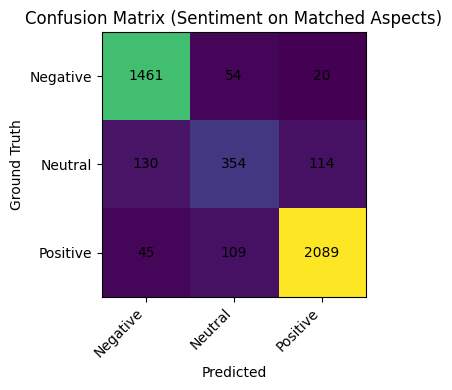

In [7]:
# ========================
# 7) Vẽ confusion matrix cho sentiment
# ========================
import matplotlib.pyplot as plt

if y_true:
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig = plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix (Sentiment on Matched Aspects)')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.yticks(range(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.tight_layout()
    plt.show()
else:
    print("Bỏ qua: không đủ dữ liệu để vẽ confusion matrix.")


In [8]:
# ========================
# 8) Điểm theo từng khía cạnh
# ========================
# (A) F1 cho **trích rút khía cạnh** theo từng nhãn
per_aspect_rows = []
aspect_vocab = set()
for s in gt_aspects_dict.values():
    aspect_vocab |= set(s)
for s in pred_aspects_dict.values():
    aspect_vocab |= set(s)
aspect_vocab = sorted(a for a in aspect_vocab if a not in IGNORE_ASPECTS)

for asp in aspect_vocab:
    # tạo dict set chỉ gồm 1 khía cạnh asp
    gt_sets = {rid: ({asp} if asp in aset else set()) for rid, aset in gt_aspects_dict.items()}
    pr_sets = {rid: ({asp} if asp in aset else set()) for rid, aset in pred_aspects_dict.items()}
    m = prf_micro_from_sets(gt_sets, pr_sets, ignore=set())  # đã tách asp nên không cần ignore
    row = {"aspect": asp, "extract_precision": m["precision"], "extract_recall": m["recall"], "extract_f1": m["f1"]}
    per_aspect_rows.append(row)

per_aspect_df = pd.DataFrame(per_aspect_rows).sort_values("extract_f1", ascending=False).reset_index(drop=True)
display(per_aspect_df.head(20))

# (B) Điểm **cảm xúc** theo từng khía cạnh (trên phần giao)
per_aspect_sent_rows = []
for asp in aspect_vocab:
    yt, yp = [], []
    for rid in all_ids:
        if asp in gt_aspects_dict.get(rid, set()) and asp in pred_aspects_dict.get(rid, set()):
            t = normalize_sentiment(gt_sents_dict.get(rid, {}).get(asp))
            p = normalize_sentiment(pred_sents_dict.get(rid, {}).get(asp))
            if t is not None and p is not None:
                yt.append(t); yp.append(p)
    if yt:
        cr = classification_report(yt, yp, labels=["Negative","Neutral","Positive"], output_dict=True, zero_division=0)
        per_aspect_sent_rows.append({
            "aspect": asp,
            "sent_macro_f1": cr["macro avg"]["f1-score"],
            "sent_accuracy": cr["accuracy"],
        })
    else:
        per_aspect_sent_rows.append({
            "aspect": asp,
            "sent_macro_f1": 0.0,
            "sent_accuracy": 0.0,
        })

per_aspect_sent_df = pd.DataFrame(per_aspect_sent_rows).sort_values("sent_macro_f1", ascending=False).reset_index(drop=True)
display(per_aspect_sent_df.head(20))


,aspect,extract_precision,extract_recall,extract_f1
0,BATTERY,0.897717,0.969428,0.932195
1,CAMERA,0.892333,0.930272,0.910908
2,PERFORMANCE,0.908571,0.813993,0.858686
3,FEATURES,0.855183,0.789030,0.820775
4,PRICE,0.741985,0.854130,0.794118
5,SCREEN,0.835391,0.754647,0.792969
6,DESIGN,0.596886,0.866834,0.706967
7,SER&ACC,0.940972,0.456998,0.615210
8,STORAGE,0.152941,0.962963,0.263959
9,4G,0.000000,0.000000,0.000000


,aspect,sent_macro_f1,sent_accuracy
0,CAMERA,0.849711,0.912249
1,SCREEN,0.834425,0.955665
2,PRICE,0.813961,0.823045
3,BATTERY,0.787584,0.895219
4,PERFORMANCE,0.735173,0.883648
5,FEATURES,0.691946,0.887701
6,DESIGN,0.685552,0.910145
7,SER&ACC,0.638808,0.940959
8,STORAGE,0.571429,0.807692
9,4G,0.000000,0.000000


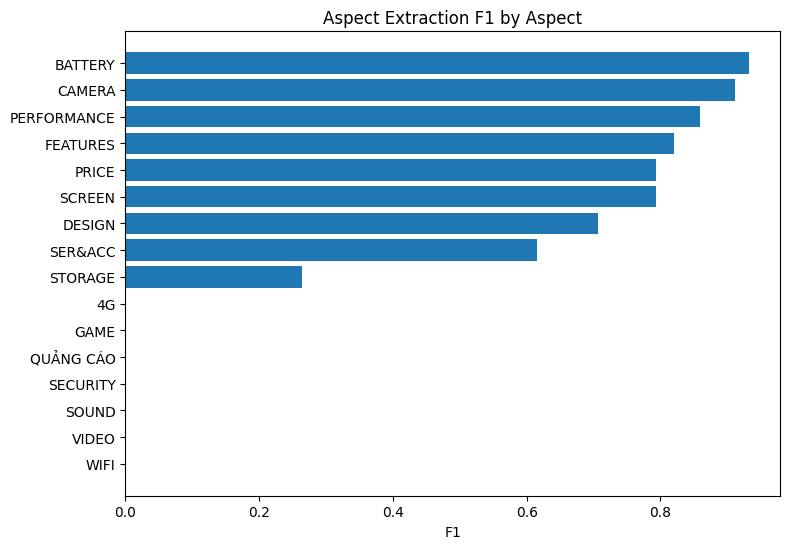

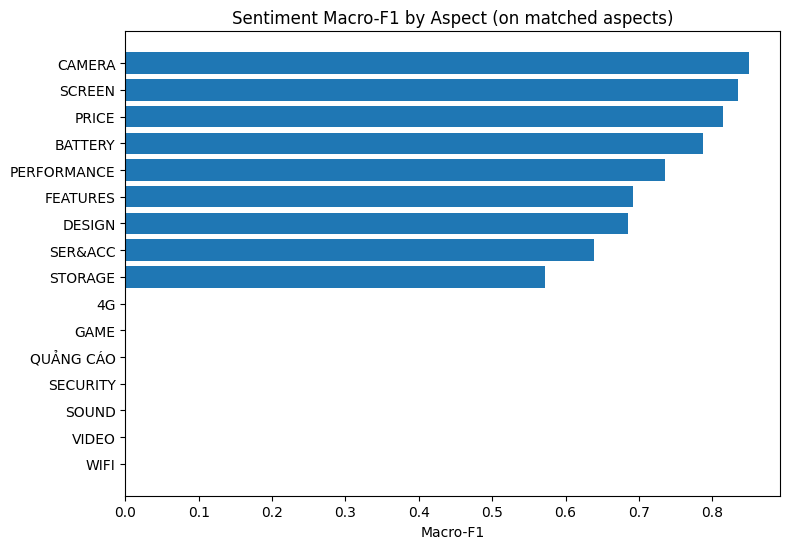

In [9]:
# ========================
# 9) Biểu đồ: F1 theo từng khía cạnh
# ========================
import matplotlib.pyplot as plt

if not per_aspect_df.empty:
    fig = plt.figure(figsize=(8, max(3, len(per_aspect_df)*0.35)))
    plt.barh(per_aspect_df["aspect"], per_aspect_df["extract_f1"])  # không chỉ định màu theo yêu cầu
    plt.title("Aspect Extraction F1 by Aspect")
    plt.xlabel("F1")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

if not per_aspect_sent_df.empty:
    fig = plt.figure(figsize=(8, max(3, len(per_aspect_sent_df)*0.35)))
    plt.barh(per_aspect_sent_df["aspect"], per_aspect_sent_df["sent_macro_f1"])  # không chỉ định màu
    plt.title("Sentiment Macro-F1 by Aspect (on matched aspects)")
    plt.xlabel("Macro-F1")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [10]:
# ========================
# 10) Phân tích lỗi (Error analysis)
# ========================
# Với mỗi review: liệt kê khía cạnh thiếu (FN), thừa (FP), và khía cạnh có sentiment sai
rows = []
gt_text_map = dict(zip(gt["review_id"], gt["comment"]))

for rid in sorted(all_ids):
    gt_as = set(a for a in gt_aspects_dict.get(rid, set()) if a not in IGNORE_ASPECTS)
    pr_as = set(a for a in pred_aspects_dict.get(rid, set()) if a not in IGNORE_ASPECTS)
    missing = sorted(gt_as - pr_as)
    extra   = sorted(pr_as - gt_as)
    wrong   = []
    common  = gt_as & pr_as
    gtm = gt_sents_dict.get(rid, {})
    prm = pred_sents_dict.get(rid, {})
    for a in sorted(common):
        t = normalize_sentiment(gtm.get(a))
        p = normalize_sentiment(prm.get(a))
        if t != p:
            wrong.append(f"{a}: GT={t} | Pred={p}")
    if missing or extra or wrong:
        rows.append({
            "review_id": rid,
            "comment": gt_text_map.get(rid, ""),
            "gt_aspects": ", ".join(sorted(gt_as)),
            "pred_aspects": ", ".join(sorted(pr_as)),
            "missing_aspects(FN)": ", ".join(missing),
            "extra_aspects(FP)": ", ".join(extra),
            "wrong_sentiments": "; ".join(wrong),
        })

errors_df = pd.DataFrame(rows)
print(f"Số review có lỗi: {len(errors_df)}")
display(errors_df.head(15))


Số review có lỗi: 1385


,review_id,comment,gt_aspects,pred_aspects,missing_aspects(FN),extra_aspects(FP),wrong_sentiments
0,0,"Điện thoải ổn. Facelock cực nhanh, vân tay ôk ...","FEATURES, PERFORMANCE, SCREEN","BATTERY, FEATURES, PERFORMANCE, SCREEN",,BATTERY,
1,1,"Mình mới mua vivo91c. Tải ứng dụng ,games nh...","FEATURES, PERFORMANCE, SER&ACC","DESIGN, PERFORMANCE, SER&ACC",FEATURES,DESIGN,SER&ACC: GT=Positive | Pred=Neutral
2,2,Xấu đẹp gì ko biết nhưng rất ưng TGdđ phục vụ ...,"DESIGN, SER&ACC","DESIGN, SER&ACC",,,DESIGN: GT=Neutral | Pred=Negative
3,3,Màn hình hơi lác khi chơi game. Game nặng thì ...,"DESIGN, PERFORMANCE","FEATURES, SCREEN","DESIGN, PERFORMANCE","FEATURES, SCREEN",
4,4,"Nói chung máy đẹp với màn amoled, ổn trong tầm...","BATTERY, DESIGN, SCREEN","BATTERY, DESIGN, PRICE, SCREEN",,PRICE,
5,5,"Đt có 3 lỗi: 1 là chế dô bỏ túi, 2 là ánh sáng...","FEATURES, SCREEN","FEATURES, SCREEN",,,SCREEN: GT=Negative | Pred=Positive
6,6,Thật tuyệt máy qua mượt túi thích như thế giớ...,,"DESIGN, PERFORMANCE, SER&ACC, STORAGE",,"DESIGN, PERFORMANCE, SER&ACC, STORAGE",
7,7,"Sản phẩm tốt, pin sài cả ngày chưa hết, chơi g...","BATTERY, CAMERA, DESIGN, PERFORMANCE, PRICE","BATTERY, CAMERA, DESIGN, PRICE",PERFORMANCE,,
8,9,Pin nhanh hết vân tay cũng chưa đk nhạy \r\nNh...,"BATTERY, FEATURES, SER&ACC","BATTERY, FEATURES",SER&ACC,,
9,10,Mới sài để cặp đã nứt màn không lên nứt nên k ...,"SCREEN, SER&ACC","BATTERY, DESIGN","SCREEN, SER&ACC","BATTERY, DESIGN",


In [11]:
# ========================
# 11) Lưu báo cáo
# ========================
from pathlib import Path
out_dir = Path("absa_eval_reports")
out_dir.mkdir(parents=True, exist_ok=True)

# Tóm tắt tổng quan
summary = {
    "ignore_aspects": sorted(list(IGNORE_ASPECTS)),
    "aspect_extraction": aspect_metrics,
    "pair_level": pair_metrics,
}

with open(out_dir / "summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

# Lưu chi tiết theo khía cạnh
per_aspect_df.to_csv(out_dir / "per_aspect_extraction.csv", index=False)
per_aspect_sent_df.to_csv(out_dir / "per_aspect_sentiment.csv", index=False)

# Lưu error analysis
errors_df.to_csv(out_dir / "errors_analysis.csv", index=False)

print("Đã lưu:")
print(" -", out_dir / "summary.json")
print(" -", out_dir / "per_aspect_extraction.csv")
print(" -", out_dir / "per_aspect_sentiment.csv")
print(" -", out_dir / "errors_analysis.csv")


Đã lưu:
 - absa_eval_reports/summary.json
 - absa_eval_reports/per_aspect_extraction.csv
 - absa_eval_reports/per_aspect_sentiment.csv
 - absa_eval_reports/errors_analysis.csv


## Gợi ý mở rộng

- **Chuẩn hoá taxonomy**: Bổ sung alias trong `ASPECT_ALIASES` nếu mô hình dùng tên khía cạnh khác tên bộ dataset.
- **Bộ lọc**: Tuỳ nhu cầu, bạn có thể **loại `GENERAL`, `OTHERS`** khỏi tính điểm (đã hỗ trợ qua `IGNORE_ASPECTS`).
- **Ghép câu**: Nếu muốn chấm ở **cấp câu** thay vì **cấp review**, bạn có thể bỏ bước `aggregate_predictions(...)` và so sánh trực tiếp trên `sent_idx` tương ứng.
- **Khuyến nghị**: Cột `recommendations` hiện **không** dùng để chấm; bạn có thể kiểm tra mức hợp lý riêng theo heuristic nếu cần.
